# ENUNCIADO

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en
`Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`.

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo témplate del item 2
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/EIA-UBA/Bimestre3/VC1/TP3

/content/drive/MyDrive/EIA-UBA/Bimestre3/VC1/TP3


In [3]:
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt
# Herramienta para navegar en el contenido de carpetas
import os
import imutils

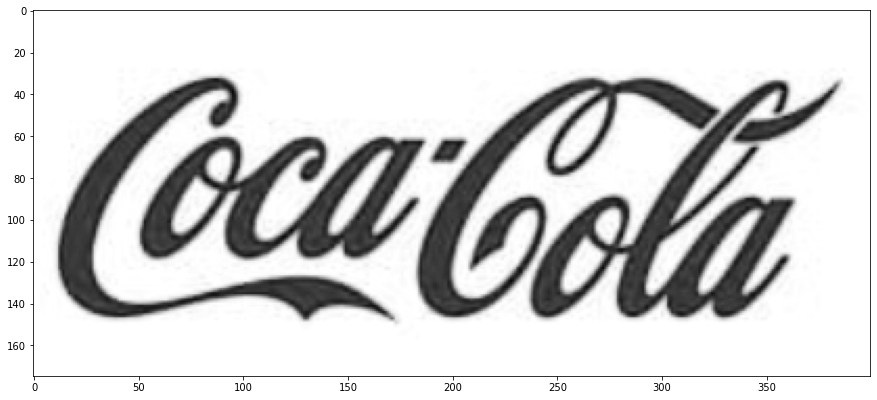

In [18]:
# Visualizo template

fileName = './template/pattern.png'
template = cv.imread(fileName, 0)
template_Canny = cv.Canny(template, 50, 200)
plt.figure(figsize=(15,15))
plt.imshow(template, cmap='gray')
plt.show()

In [5]:
tW, tH = template.shape[::-1]
print('Tamaño del template:', str(tW), 'x', str(tH))

Tamaño del template: 400 x 175


Tamaño de imagen logo_1.png :  687 x 450
Tamaño de imagen COCA-COLA-LOGO.jpg :  1389 x 1389
Tamaño de imagen coca_logo_2.png :  233 x 363
Tamaño de imagen coca_retro_1.png :  715 x 493
Tamaño de imagen coca_multi.png :  799 x 598
Tamaño de imagen coca_retro_2.png :  715 x 429
Tamaño de imagen coca_logo_1.png :  207 x 500


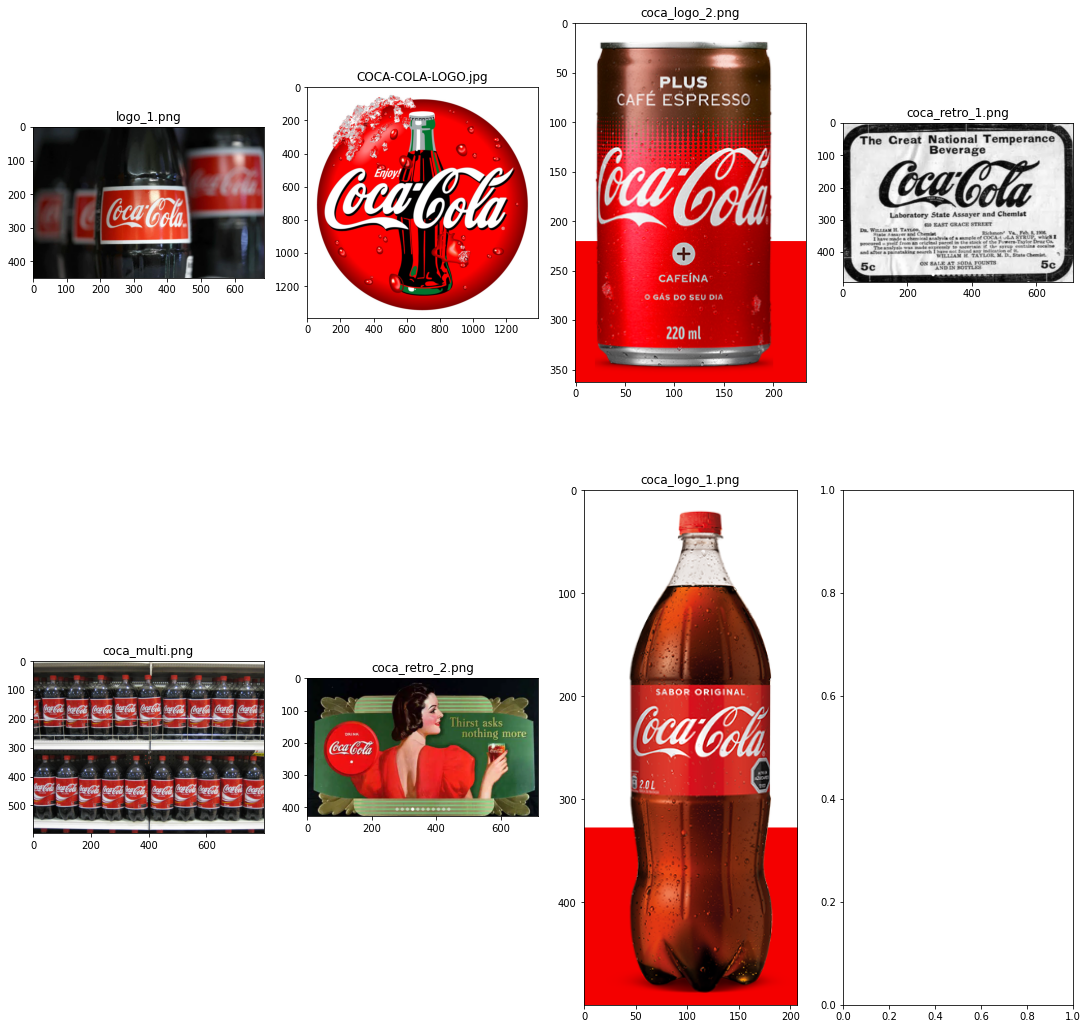

In [6]:
# Visualizo imagenes donde se buscará el patrón

directory = './images/'
fileNames = os.listdir(directory)

cont = 0
fig, axs = plt.subplots(2, 4, constrained_layout=True, figsize=(15,15))
for i in range(2):
  for j in range(4):
    figurePath = directory+fileNames[cont]
    img = cv.imread(figurePath)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgW, imgH = img_gray.shape[::-1]
    print('Tamaño de imagen', fileNames[cont], ': ', str(imgW), 'x', str(imgH))
    axs[i, j].imshow(img_rgb)
    axs[i, j].set_title(fileNames[cont])
    cont += 1
    if cont==7:
      break


## Item 1: obtención del logo en cada imagen sin falsos positivos

In [52]:
# Función para encontrar template dentro de una imagen
def findTemplate(img, fileName, template, methods):

  scales_img = np.linspace(0.25, 2.5, 25)[::-1] #np.linspace(0.2, 3.5, 50)[::-1]
  scales_tmp = np.linspace(0.25, 2.5, 25)[::-1] #[0.8, 0.9, 1, 1.1, 1.2] #np.linspace(0.5, 1.5, 10)[::-1]
  RES = np.zeros((len(scales_img)*len(scales_tmp),5))
  for i, meth in enumerate(methods):
  
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img.copy()
    img_salida = cv.cvtColor(img_salida, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    method = eval(meth)

    cont = 0
    # loop over the scales of the image
    for scale_img in scales_img:
      for scale_tmp in scales_tmp:

        # resize the image according to the scale, and keep track
        # of the ratio of the resizing
        r_img = int(img_gray.shape[1]*scale_img)
        r_tmp = int(template.shape[1]*scale_tmp)
        img_resized = imutils.resize(img_gray, width=r_img)
        tmp_resized = imutils.resize(template, width=r_tmp)

        # if the resized image is smaller than the template, then break
        # from the loop
        if img_resized.shape[0] < tmp_resized.shape[0] or img_resized.shape[1] < tmp_resized.shape[1]:
          continue

        else:
          # detect edges in the resized, grayscale image and apply template
          # matching to find the template in the image
          img_Canny = cv.Canny(img_resized, 50, 200)
          tmp_Canny = cv.Canny(tmp_resized, 50, 200)
          res = cv.matchTemplate(img_Canny, tmp_Canny, method)
    
          # Encontramos los valores máximos y mínimos
          min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
              
          # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
          if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
              top_left = min_loc
          else:
              top_left = max_loc
              if 'NORMED' in meth:
                confidence = res[top_left[1]][top_left[0]]
              else:
                confidence = max_val/(max_val+np.abs(min_val))
          
          RES[cont, :] = np.array([r_img, r_tmp, top_left[0], top_left[1], confidence])

        cont += 1

  #return RES
  idx_max = np.argmax(RES[:, -1])
  (r_img, r_tmp, top_left_x, top_left_y, confidence) = RES[idx_max, :]
  top_left = (int(top_left_x), int(top_left_y))
  img_salida = imutils.resize(img_salida, width=int(r_img))
  tmp_salida = imutils.resize(template, width=int(r_tmp))
  tW, tH = tmp_salida.shape[::-1]

  # Marcamos el lugar donde lo haya encontrado
  #----------------------------------------
  bottom_right = (top_left[0] + tW, top_left[1] + tH)
  cv.rectangle(img_salida, top_left, bottom_right, (0,0,255), 2)
  cv.putText(img_salida, 'Confidence: '+str(np.round(confidence,3)), top_left, cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        
  # Graficamos el procesamiento y la salida
  #----------------------------------------
    
  # Imagen original con recuadros
  plt.figure(figsize=(10,10))
  plt.imshow(img_salida) #(imutils.resize(img_salida,width=int(img_gray.shape[1])))
  #plt.set_title('Detected Point')
  #plt.set_xticks([])
  #plt.set_yticks([])

  return RES

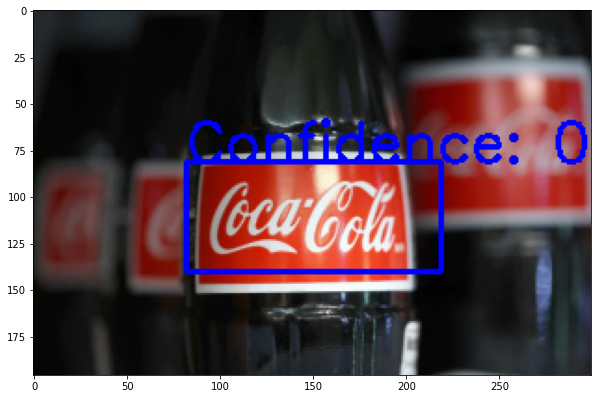

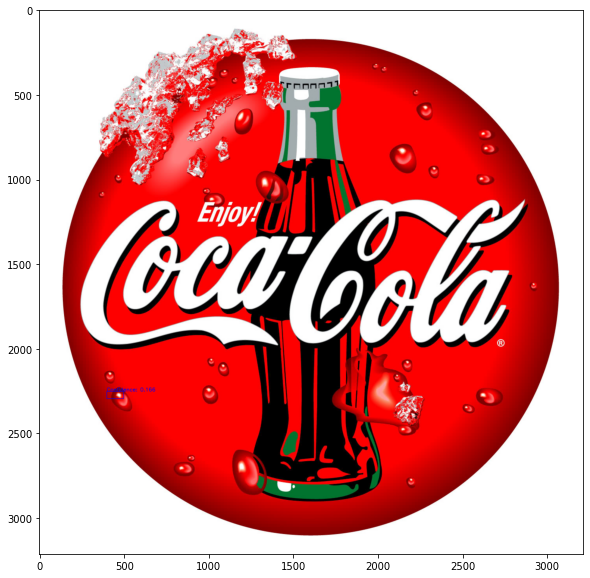

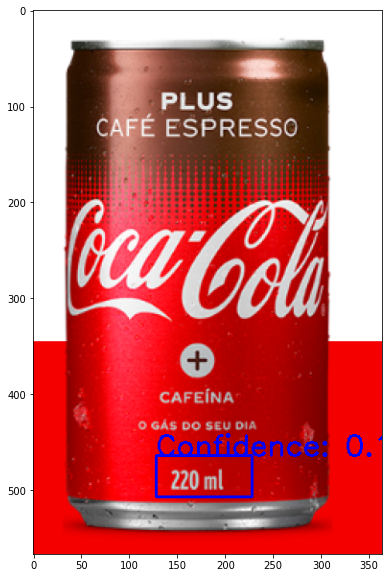

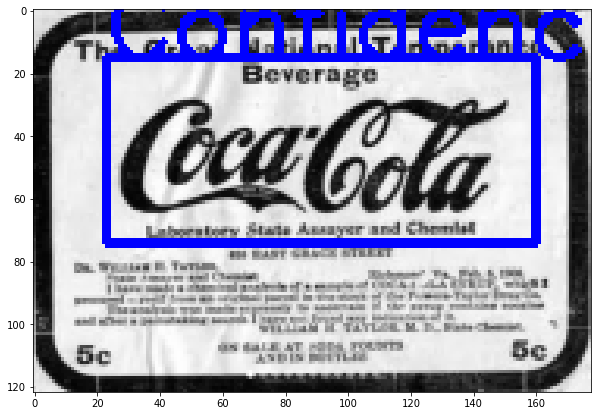

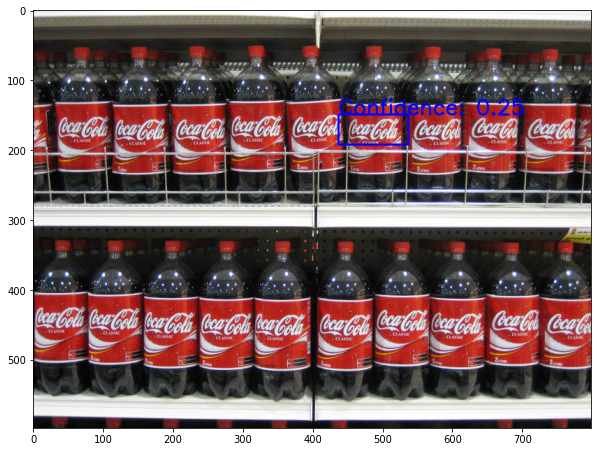

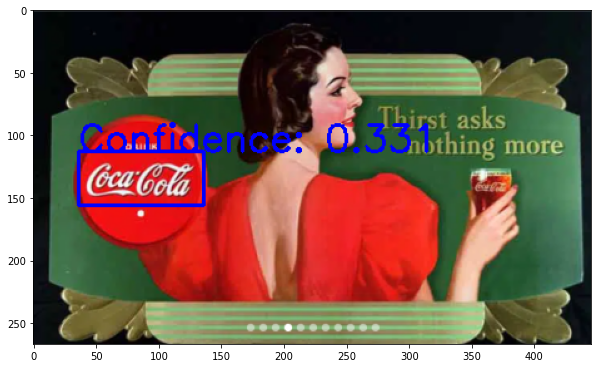

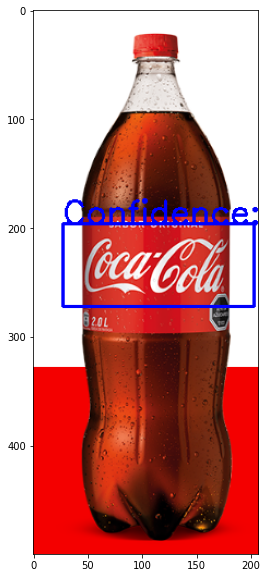

In [53]:
methods = ['cv.TM_CCOEFF_NORMED'] #'cv.TM_CCOEFF', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED'

for i in range(len(fileNames)):
  figurePath = directory+fileNames[i]
  img = cv.imread(figurePath)
  RES = findTemplate(img, fileNames[i], template, methods)
  if fileNames[i]=='coca_multi.png':
    RES_multi = RES.copy()

## Item 2: algoritmo para multiples detecciones

In [54]:
idx_max = np.argmax(RES_multi[:, -1])
(r_img, r_tmp, top_left_x, top_left_y, confidence) = RES_multi[idx_max, :]
print(r_img, r_tmp, top_left_x, top_left_y, confidence)

799.0 100.0 437.0 149.0 0.2503780126571655


In [55]:
figPath = './images/coca_multi.png'
img = cv.imread(figPath)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_rgb_resized = imutils.resize(img_rgb, width=int(r_img))
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray_resized = imutils.resize(img_gray, width=int(r_img))
tmp_resized = imutils.resize(template, width=int(r_tmp))

img_Canny = cv.Canny(img_gray_resized, 50, 200)
tmp_Canny = cv.Canny(tmp_resized, 50, 200)
w, h = tmp_resized.shape[::-1]
res = cv.matchTemplate(img_Canny, tmp_Canny, cv.TM_CCOEFF_NORMED)
max_res = res[int(top_left_y)][int(top_left_x)]
print(max_res)

0.250378


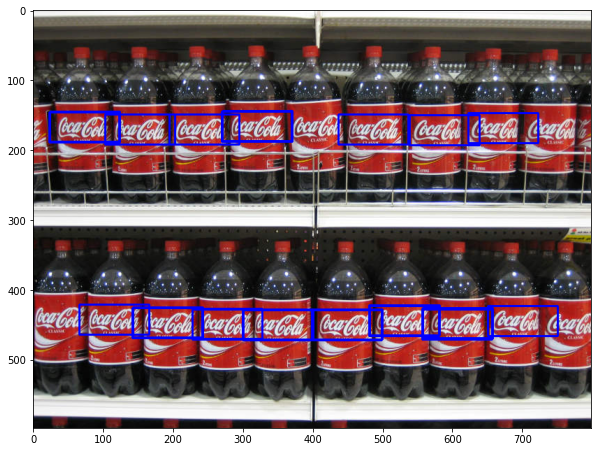

In [56]:
# Fijamos un umbral de "coincidencia"
threshold = 0.7*max_res
loc = np.where(res>=threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb_resized, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb_resized)
plt.show()